# Part I. One-sided finite differences

Write a function, `deriv`, which computes a derivative of its argument at a given point, $x$, using a one-sided finite difference rule with a given step side $h$, with the approximation order of $O(h^2)$. 

In [4]:
def deriv(f, x, h):
    """ Compute a derivative of `f` at point `x` with step size `h`.
    
    Compute the derivative using the one-sided rule of the approximation order of $O(h^2)$.
    
    Parameters
    ----------
    f : callable
        The function to differentiate
    x : float
        The point to compute the derivative at.
    h : float
        The step size for the finite different rule.
        
    Returns
    -------
    fder : derivative of f(x) at point x using the step size h.
    """
    return (-1.5 * f(x) + 2 * f(x + h) - 0.5 * f(x + 2 * h)) / h

#### Test I.1

Test your function on a simple test case: differentiate $f(x) = x^3$ at $x=0$. Comment on whether your results are consistent with the expected value of $f'(x) = 0$ and on an expected scaling with $h\to 0$.

 (10% of the total grade)

In [222]:
x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(lambda x: x**3, x, h)
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.0002
0.001000 --  -2e-06
0.000100 --  -2e-08
0.000010 --  -2e-10


As we predicted, the error behaves as a quadratic fucntion of a step $err$ ~ $h^2$

### Test I.2

Now use a slightly more complicated function, $f(x) = x^2 \log{x}$, evaluate the derivative at $x=1$ using your one-sided rule and a two-point one-sided rule. Roughly estimate the value of $h$ where the error stops decreasing, for these two schemes. 
(15% of the total grade)

In [56]:
from math import log

def f(x):
    return x**2 * log(x)
    
def fder(x):
    return x * (2.*log(x) + 1)

def basic_deriv(f, x, h):
    return (f(x + h) - f(x)) / h

Optimal step for a two-point one-sided rule is  1.0000000000000005e-08  with a error of  8.922528271781971e-09
Optimal step for a high-accuracy one-sided rule is  1.0000000000000003e-05  with a error of  4.9012571778916936e-11


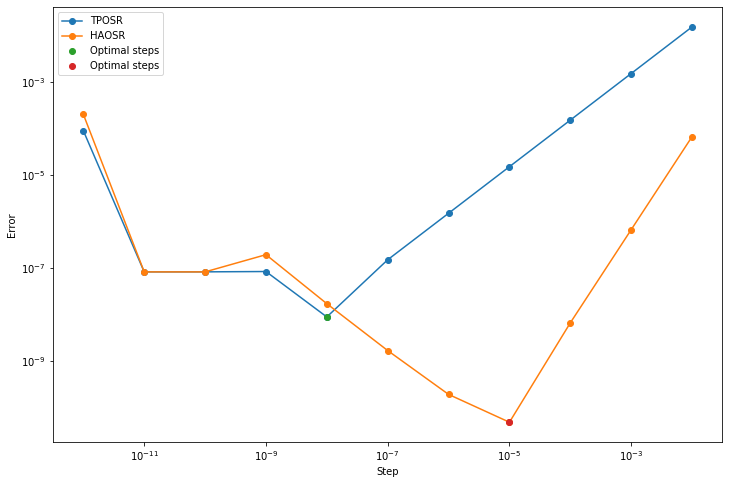

In [176]:
import numpy as np
import matplotlib.pyplot as plt

x0 = 1

der_b = []
der = []
err_b = []
err = []
real_value = fder(x0)
h_arr = np.power(0.1, np.arange(2, 13))[::-1]

for h in h_arr:
    der_b.append(basic_deriv(f, x0, h))
    err_b.append(np.abs(der_b[-1] - real_value))
    
    der.append(deriv(f, x0, h))
    err.append(np.abs(der[-1] - real_value))

ind = len(err_b) - 1
while err_b[ind] > err_b[ind - 1]:
    ind -= 1
opt_h_b = h_arr[ind]
err_h_b = err_b[ind]

ind = len(err) - 1
while err[ind] > err[ind - 1]:
    ind -= 1
opt_h = h_arr[ind]
err_h = err[ind]

print('Optimal step for a two-point one-sided rule is ', opt_h_b, ' with a error of ', err_h_b)
print('Optimal step for a high-accuracy one-sided rule is ', opt_h, ' with a error of ', err_h)

plt.figure(figsize=(12,8))
plt.plot(h_arr, err_b, '-o', label='TPOSR')
plt.plot(h_arr, err, '-o', label='HAOSR')
plt.plot(opt_h_b, err_h_b, 'o', opt_h, err_h, 'o', label='Optimal steps')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Error')
plt.legend()
plt.show()

### Test I.3 

Now try differentiating $x^2 \log(x)$ at $x=0$. Use the three-point one-sided rule. Note that to evaluate the function at zero, you need to special-case this value. Check the scaling of the error with $h$, explain your results. 
(25% of the total grade)

In [219]:
def f(x):
    if x == 0:
        # the limit of $x^2 log(x)$ at $x-> 0$ is zero, even though log(x) is undefined at x=0
        return 0.0
    else:
        return x**2 * log(x)
    
def fder(x):
    if x == 0:
        return 0.0
    else:
        return x*(2*log(x) + 1)

x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = np.abs(deriv(f, x, h) - fder(x))
    print("%5f -- %7.4g" % (h, err))

0.010000 -- 0.01386
0.001000 -- 0.001386
0.000100 -- 0.0001386
0.000010 -- 1.386e-05


$err$ ~ $h$, it depends on the value of higher derivetives at the point x. That's why first example worked so good: the fucntion $x^n$ is simply perfect for that method.

# Part II. Midpoint rule 

Write a function which computes a definite integral using the midpoint rule up to a given error, $\epsilon$. Estimate the error by comparing the estimates of the integral at $N$ and $2N$ elementary intervals. 

In [218]:
def midpoint_rule(func, a, b, eps, timeout = 60):
    #Timeout is the time after which the code stops and returns a current value of the integral
    from time import time
    start = time()
    #So, the problem here is that, if we compute an integral with 2 * N intervals and then reach
    #that number again, it will be computed again for no reason. As a result, we need to save the values
    I = np.array([np.inf])
    converged = False
    #A number of intervals
    n = 1
    
    while ~converged and time() - start < timeout:
        #We need to compute an approximation only if there is nothing there already
        if I[n - 1] == np.inf:
            step = (b - a) / n
            points = np.arange(a + step / 2, b, step)
            I_0 = step * np.sum([func(point) for point in points])
            I[n - 1] = I_0
        
        #Every step we need to add a value of "doubled" integral because it
        #will always be out of boundaries of an array I
        step = (b - a) / (2 * n)
        points = np.arange(a + step / 2, b, step)
        I_double = step * np.sum([func(point) for point in points])

        #Of course, there are some over numbers between N and 2 * N (except N = 1),
        #so, to add an 2 * N integral, we need to feel everything else with infinities
        #to compute it later in the previous step
        addition = np.full(2 * n - I.shape[0], np.inf)
        addition[-1] = I_double
        I = np.append(I, addition)

        #Checking convergence and increasing the number of intervals
        converged = (np.abs(I[n - 1] - I[2 * n - 1]) < eps)
        n += 1
        
    return (I[n - 2], n, converged)

### Test II.1

Test your midpoint rule on a simple integral, which you can calculate by paper and pencil.

Compare the rate of convergence to the expected $O(N^{-2})$ scaling by studying the number of intervals required for a given accuracy $\epsilon$.

Compare the numerical results to the value you calculated by hand. Does the deviation agree with your estimate of the numerical error?
(20% of the total grade)


In [192]:
func1 = lambda x: x
func2 = lambda x: x**3
func3 = lambda x: np.sin(x)

eps = 1e-5

print('Integral of a fucntion f(x) = x on an interval from 4 to 10\nMidpoint rule: %2f; Real value: 42\n' % midpoint_rule(func1, 4, 10, eps)[0])
print('Integral of a fucntion f(x) = x^3 on an interval from 2 to 3\nMidpoint rule: %2f; Real value: 16.25\n' % midpoint_rule(func2, 2, 3, eps)[0])
print('Integral of a fucntion f(x) = sin(x) on an interval from pi to 3 * pi\nMidpoint rule: %2f; Real value: 0\n' % midpoint_rule(func3, np.pi, 3 * np.pi, eps)[0])
#print('Integral of a fucntion f(x) = x**2 * ln(x) on an interval from 0 to 100 * pi\nMidpoint rule: %.3f; Real value: 10^6 / 9 * (3 * ln(100) - 1) = %.3f\n' % (midpoint_rule(f, 0, 100, 1e-4)[0], 10**6 / 9 * (3 * np.log(100) - 1)))

Integral of a fucntion f(x) = x on an interval from 4 to 10
Midpoint rule: 42.000000; Real value: 42

Integral of a fucntion f(x) = x^3 on an interval from 2 to 3
Midpoint rule: 16.249987; Real value: 16.25

Integral of a fucntion f(x) = sin(x) on an interval from pi to 3 * pi
Midpoint rule: -0.000000; Real value: 0



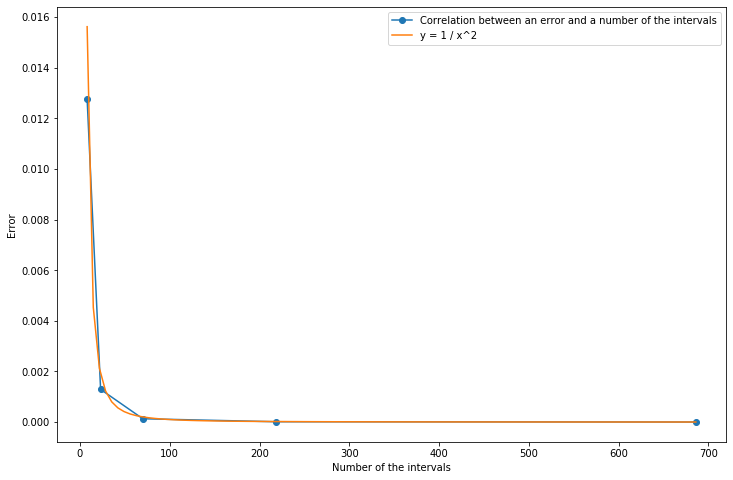

In [193]:
err = []
eps_arr = np.power(0.1, np.arange(2,7))
n_arr = []

for eps in eps_arr:
    res = midpoint_rule(func2, 2, 3, eps)
    err.append(np.abs(res[0] - 16.25))
    n_arr.append(res[1])
    
x = np.linspace(n_arr[0], n_arr[-1], 100)
y = x**(-2)

plt.figure(figsize=(12,8))
plt.plot(n_arr, err, '-o', label='Correlation between an error and a number of intervals')
plt.plot(x, y, '-', label='y = 1 / x^2')
plt.xlabel('Number of intervals')
plt.ylabel('Error')
plt.legend()
plt.show()
    

### Test II.2

Now use your midpoint rule to compute the value of

$$
\int_0^1\! \frac{\sin{\sqrt{x}}}{x}\, dx
$$

up to a predefined accuracy of $\epsilon=10^{-4}$.

Note that the integral contains an integrable singularity at the lower limit. Do calculations two ways: first, do a straightforward computation; next, subtract the singularity. Compare the number of iterations required to achieve the accuracy of $\epsilon$.

(30% of the total grade)

In [200]:
func = lambda x: np.sin(np.sqrt(x)) / x
a = 0
b = 1
eps = 1e-4

I_straight = midpoint_rule(func, a, b, eps)
print(I_straight)

(1.8828742564741885, 4239, False)


In [215]:
func1 = lambda x: np.sin(np.sqrt(x)) / x - 1 / np.sqrt(x)
func2 = lambda x: 1 / np.sqrt(x)

I_1 = midpoint_rule(func1, a, b, eps)
I_2 = 2
I = I_1[0] + I_2
print((I, I_1[1], I_1[2]))

(1.8920193180026725, 17, True)


We were using a method of seperating a singularity from an initial function. Here we have $\frac{\sin{\sqrt{x}}}{x} = \frac{1}{\sqrt{x}} + O(x^{1/2})$, so 2 new fucntions are $\frac{\sin{\sqrt{x}}}{x} - \frac{1}{\sqrt{x}}$ and $\frac{1}{\sqrt{x}}$. An integral from the second one is very easy: 
$$
\int_0^1\! \frac{1}{\sqrt{x}}\, dx = 2
$$
So the only thing left is the first integral:
$$
\int_0^1\! (\frac{\sin{\sqrt{x}}}{x} - \frac{1}{\sqrt{x}})\, dx
$$
As we can see, there is a timeout on a straight computation variant (a code was running for 1 minute straight).

There is another transformation of the integral that helps to get rid of the singularity using a substitution $y = \sqrt{x}$:
$$
\int_0^1\! \frac{\sin{\sqrt{x}}}{x}\, dx = 2 \int_0^1\! \frac{\sin{y}}{y}\, dy
$$

In [225]:
func = lambda x: np.sin(x) / x

I = midpoint_rule(func, a, b, eps)
print(I)
print(2 * I[0])

(0.9462085788431454, 11, True)
1.8924171576862907


The most accurate and fast computation. Nice! :)